# Assignment 1: Street View {-}
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build a model that recognizes the correct digit.

In [61]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import warnings
import time
import os
import copy

#sklearn specific imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn import svm

In [2]:
warnings.filterwarnings("ignore")

In [ ]:
#these lines are commented to avoid importing local
import pandas as pd

# Massimo local import
#svhn = pd.concat(pd.read_csv(r"C:\Users\massi\Downloads\svhn (1).csv", chunksize=10000))

# Fabian local import 
svhn = pd.concat(pd.read_csv(r"/media/fabian/Seagate Expansion Drive/svhn.csv", chunksize=100000))

In [4]:
X = svhn.iloc[:,:-1].to_numpy()
y = svhn.iloc[:,-1].to_numpy()

In [3]:
# Download Streetview data. Takes a while the first time.
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
target=SVHN.default_target_attribute)

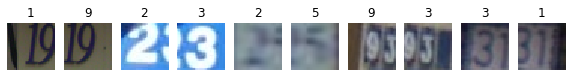

In [4]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X), figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
    for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

In [5]:
print(X.shape, y.shape)

(99289, 3072) (99289,)


> **Instructions and advice (remove before submission)**
>  
> * Answer the questions in this notebook, including the code, results, and discussions. 
> * Add precise explanations when interpreting the results of your experiments. Use markdown cells for this.
> * Submit both this notebook and a PDF through Canvas. To create the PDF, see File > Export Notebook as PDFs.
> * Submit only one notebook and one PDF per team. In Jupyter Lab, you can copy-paste cells (with results) into a single notebook. 
> * Keep the PDF below 20 pages. Remove these instructions and the general advise below in the final PDF.
> * Avoid all(!) unnecessary outputs. Only output the answers to the questions. Add ';' behind lines that > generate output to suppress unnecessary output.
> * All tasks can be completed with scikit-learn. You are allowed (but not required) to use other tools as well.
> * Training models can take time. Make sure to start computations well in advance of the deadline. 
> * Be efficient. Don't try every model on all the data at once. Test your code on a small part of the data (even just 1%) until you are sure that there are no more bugs or other issues.
> * Observe how long it takes to train different models on a small part of your data to learn whether the models are fast enough for what you want to do.
> * You are allowed to run code elsewhere (e.g. in Python scripts) and store the results on file. If so, copy the code in this notebook and load/visualize/discuss the results here as well.
> * On [Google Colab](https://colab.research.google.com/) you can run the notebook in the cloud.

### Team details {-}
Add the names of all team members and a short description of each member's contributions.   

- #### TEAM MEMBER 1 = Maury 

    Description of work:

- #### TEAM MEMBER 2 = Daan

    Description of work:

- #### TEAM MEMBER 3 = Massimo

    Description of work:

- #### TEAM MEMBER 4 = Dayana 

    Description of work:

- #### TEAM MEMBER 5 = Fabian

    Description of work:


## 1. Evaluate different models (15 points) {-}
- Take a stratified 10% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample. 
- Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. 
    - Use cross-validation with 3 folds, output the training accuracy and test accuracy including the standard deviations.
- Discuss the results. Are they what you expected? Are the model over/underfitting? What does the standard deviation tell you? Do you think you can get better results with more training data?

In [5]:
# with 1% subsample for now. remove a zero from train_size and test_size in final version
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.075, test_size=0.025, stratify=y, random_state=0)

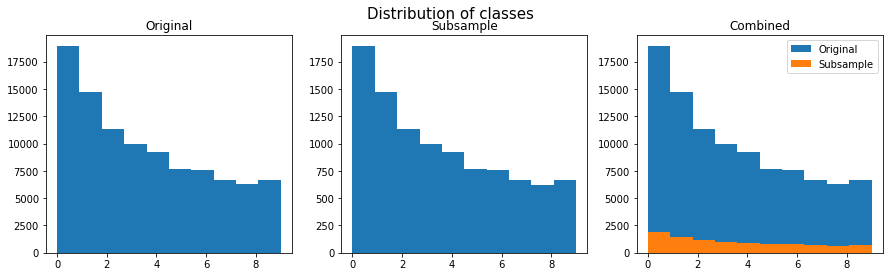

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = [15,4])
fig.suptitle('Distribution of classes', size = 15)
ax1, ax2, ax3 = axes.flatten()

ax1.hist(y)
ax1.set_title('Original')

ax2.hist(np.append(y_train,y_test))
ax2.set_title('Subsample')

ax3.hist(y, label = 'Original')
ax3.hist(np.append(y_train,y_test), label = 'Subsample')
ax3.legend(prop={'size': 10})
ax3.set_title('Combined')

plt.show()

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7446, 3072), (2483, 3072), (7446,), (2483,))

In [44]:
np.append(y_train,y_test).shape

(9929,)

In [7]:
def knn(X_train, X_test, y_train, y_test):

    knn = KNeighborsClassifier().fit(X_train, y_train)
    knntrainacc = knn.score(X_train, y_train)
    knntestacc = knn.score(X_test, y_test)
    knncv = cross_val_score(knn, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)

    print("KNN evaluation\n")
    print("Training accuracy: {}%".format(round(knntrainacc*100,1)))
    print("Test accuracy: {}%".format(round(knntestacc*100,1)))
    print("3-folds cross-validation score: {} (+/- {})%".format(round(knncv.mean()*100,1), round((knncv.std()*100*2),1)))
    
    return knncv.mean()

In [70]:
knn(X_train, X_test, y_train, y_test);

KNN evaluation

Training accuracy: 56.9%
Test accuracy: 36.0%
3-folds cross-validation score: 35.7 (+/- 0.8)%


In [8]:
def logreg(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression().fit(X_train, y_train)
    logregtrainacc = logreg.score(X_train, y_train)
    logregtestacc = logreg.score(X_test, y_test)
    logregcv = cross_val_score(logreg, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)

    print("Logistic regression evaluation\n")
    print("Training accuracy: {}%".format(round(logregtrainacc*100,1)))
    print("Test accuracy: {}%".format(round(logregtestacc*100,1)))
    print("3-folds cross-validation score: {} (+/- {})%".format(round(logregcv.mean()*100,1), round((logregcv.std()*100*2),1)))
    
    return logregcv.mean()

In [48]:
logreg(X_train, X_test, y_train, y_test);

Logistic regression evaluation

Training accuracy: 70.9%
Test accuracy: 16.1%
3-folds cross-validation score: 16.6 (+/- 0.8)%


In [9]:
def lsvm(X_train, X_test, y_train, y_test):

    lsvm = LinearSVC().fit(X_train, y_train)
    lsvmtrainacc = lsvm.score(X_train, y_train)
    lsvmtestacc = lsvm.score(X_test, y_test)
    lsvmcv = cross_val_score(lsvm, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)

    print("Linear support vector machine evaluation\n")
    print("Training accuracy: {}%".format(round(lsvmtrainacc*100,1)))
    print("Test accuracy: {}%".format(round(lsvmtestacc*100,1)))
    print("3-folds cross-validation score: {} (+/- {})%".format(round(lsvmcv.mean()*100,1), round((lsvmcv.std()*100*2),1)))
    
    return lsvmcv.mean()

In [50]:
lsvm(X_train, X_test, y_train, y_test);

Linear support vector machine evaluation

Training accuracy: 39.0%
Test accuracy: 15.8%
3-folds cross-validation score: 16.2 (+/- 2.6)%


### Discussion

As expected the performance of $k$-Nearest Neighbors is pretty bad. This model suffers from the "curse of dimensionality". This means that for any two points their Eucledian distance becomes the same as the number of dimensions increase. The training accuracy is not that good and the model seems to underfit. The testing accuracy is terrible. The logic regression model is heavily overfitting. It has a high training accuracy while the testing accuracy is very low. The SVM model has descent training accuracy but also low testing accuracy, it perform similar to the $k$-Nearest Neighbors model. 

We have trained the models with more data aswell, this does not significantly improve performance of the models (possibly add numbers if computationally feasible). Accuracies are acquired with low standarddeviations. This means that the 3 fold used in training are very similar. These standarddeviations improve as more data is used for training. <i> e.g. </i> $k$-Nearest Neighbors yields a training accuracy of $24.0 \pm 6.2\%$ and $35.7 \pm 0.8\%$ with a 0.0075 and 0.01 $test\_size$ respectively.

## 2. Learning curves (20 points) {-}
- Start with a 1% stratified subsample of the original data. Train all 3 classifiers and record both the accuracy (same as above) and the [training time](https://pythonhow.com/measure-execution-time-python-code/).  
- Repeatedly **add** 1% more statified data (don't take a completely new 2% subsample). Measure accuracy and training time again.
- Continue to at least 10% of the original data. Plot the results as a line graph, with training set size on the x-axis and accuracy and training time, respectively, on the y-axes.
    - If the algorithms are sufficiently fast, you can continue to 100% as well.
- Discuss your results. Which algorithms are fast/slow? Which require more data to get better results? Which ones tend to overfit? Which ones would benefit from more data?

In [212]:
#variables here are only so that X and y remain "the whole dataset"
xt = X#[:5000,:]
yt = y#[:5000]
print(xt.shape, yt.shape)

(99289, 3072) (99289,)


In [214]:
init_start = time.time();

#Adjust this if you want more bigger percent of sample
max_percentage = 11;

#This is needed later on for plotting
knncvs, logregcvs, lsvmcvs, knntime, logregtime, lsvmtime = [],[],[],[],[],[]

print('-' * 102)
print('KNN'.center(width))
print('-' * 102)
print('Subsample(%) \tTraining Accuracy \tTesting Accuracy \tKfold mean \tSamples \tTime')

for i in range(1,max_percentage):
    X_train, X_test, y_train, y_test = train_test_split(xt, yt, train_size=0.75*(i/100), test_size=0.25*(i/100), random_state=0)
    
    start = time.time()
    model = KNeighborsClassifier().fit(X_train, y_train)
    end = time.time()
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    cv_score = cross_val_score(model, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)
    knncvs.append(cv_score.mean())
    knntime.append(end-start)
    print('%d \t\t%.4f \t\t\t%.4f \t\t\t%.4f \t\t%d \t\t%.4f ' % (i, train_score, test_score, cv_score.mean(), X_train.shape[0], (end-start)))

print('\n')
print('-' * 102)
print('Logistic regression'.center(width))
print('-' * 102)
print('Subsample(%) \tTraining Accuracy \tTesting Accuracy \tKfold mean \tSamples \tTime')    

for i in range(1,max_percentage):
    X_train, X_test, y_train, y_test = train_test_split(xt, yt, train_size=0.75*(i/100), test_size=0.25*(i/100), random_state=0)
    
    start = time.time()
    model = LogisticRegression().fit(X_train, y_train)
    end = time.time()
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    cv_score = cross_val_score(model, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)
    logregcvs.append(cv_score.mean())
    logregtime.append(end-start)
    print('%d \t\t%.4f \t\t\t%.4f \t\t\t%.4f \t\t%d \t\t%.4f ' % (i, train_score, test_score, cv_score.mean(), X_train.shape[0], (end-start)))

print('\n')
print('-' * 102)
print('Support Vector Machine'.center(width))
print('-' * 102)
print('Subsample(%) \tTraining Accuracy \tTesting Accuracy \tKfold mean \tSamples \tTime')

for i in range(1,max_percentage):
    X_train, X_test, y_train, y_test = train_test_split(xt, yt, train_size=0.75*(i/100), test_size=0.25*(i/100), random_state=0)
    
    start = time.time()
    model = LinearSVC().fit(X_train, y_train)
    end = time.time()
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    cv_score = cross_val_score(model, np.concatenate((X_train, X_test)), np.append(y_train,y_test), cv=3)
    lsvmcvs.append(cv_score.mean())
    lsvmtime.append(end-start)
    print('%d \t\t%.4f \t\t\t%.4f \t\t\t%.4f \t\t%d \t\t%.4f ' % (i, train_score, test_score, cv_score.mean(), X_train.shape[0], (end-start)))

final = time.time();
minute = (final-init_start)/60
sec = (final-init_start)%60
print('\n')
print('Total running time: %d min %d s' % (minute, sec))
print(len(knntime), len(logregcvs), len(lsvmcvs), len(knntime), len(logregtime), len(lsvmtime))

------------------------------------------------------------------------------------------------------
                                                          KNN                                                           
------------------------------------------------------------------------------------------------------
Subsample(%) 	Training Accuracy 	Testing Accuracy 	Kfold mean 	Samples 	Time
1 		0.4704 			0.2289 			0.2467 		744 		0.0928 
2 		0.4963 			0.2777 			0.2648 		1489 		0.2510 
3 		0.5045 			0.3020 			0.2910 		2234 		0.4374 
4 		0.5218 			0.3072 			0.2969 		2978 		0.6092 
5 		0.5294 			0.3333 			0.3062 		3723 		0.8149 
6 		0.5336 			0.3389 			0.3226 		4468 		1.3267 
7 		0.5474 			0.3521 			0.3332 		5212 		1.3007 
8 		0.5496 			0.3333 			0.3339 		5957 		1.5244 
9 		0.5583 			0.3351 			0.3425 		6702 		1.7703 
10 		0.5650 			0.3464 			0.3422 		7446 		2.1891 


------------------------------------------------------------------------------------------------------
           

In [215]:
print(knncvs)
print(lsvmcvs)
print(logregcvs)

[0.24671942733212202, 0.2648302827605904, 0.29104708603627755, 0.29692626124261184, 0.30615735981430997, 0.32260286867369586, 0.3332454959468227, 0.33387899481554745, 0.3425100278712634, 0.3422232632358475]
[0.12796792531585363, 0.14149933898962289, 0.12149488223392575, 0.13501131504720232, 0.1311733254740063, 0.12338984570905069, 0.15781118298289917, 0.14614797052276732, 0.12452339902535914, 0.12487616419043712]
[0.1349594893159395, 0.13240905286225094, 0.15038744269963114, 0.1435385845651822, 0.16174929708637054, 0.16298327477758182, 0.16158693527443438, 0.16530575066231176, 0.16012106334455348, 0.17443865256419663]


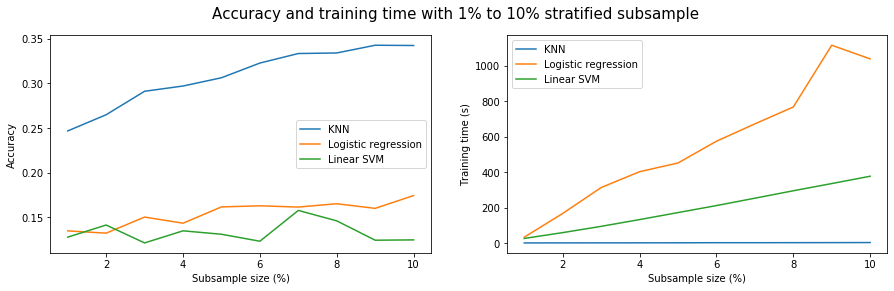

In [216]:
subsamplesize = list(range(1,max_percentage))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [15,4])
fig.suptitle('Accuracy and training time with 1% to 10% stratified subsample', size = 15)
ax1, ax2 = axes.flatten()

ax1.plot(subsamplesize, knncvs, label = "KNN")
ax1.plot(subsamplesize, logregcvs, label = "Logistic regression")
ax1.plot(subsamplesize, lsvmcvs, label = "Linear SVM")
ax1.legend(prop={'size': 10})
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Subsample size (%)')

ax2.plot(subsamplesize, knntime, label = "KNN")
ax2.plot(subsamplesize, logregtime, label = "Logistic regression")
ax2.plot(subsamplesize, lsvmtime, label = "Linear SVM")
ax2.legend(prop={'size': 10})
ax2.set_ylabel('Training time (s)')
ax2.set_xlabel('Subsample size (%)')

plt.show()

### Discussion

In general, all 3 algorithms tend to perform better as the sample size increases. Both training- and testing accuracy improves aswell as the $cros\_validated$ performance. The $k$-Nearest Neigbors model thrives under addition of data in particular, as kan be seen from the rising line in the left plot above. The linear SVM model and logistic regression model also see improved performance to a lesser extent as data increases. Also, they are computionally more expensive.

$k$-Nearast Neigbors is the fastest of the three test models. The training time of both $k$-Nearest Neigbors and linear SVM appear to increase linearly with inceasing data whereas the Logistic Regression model seems to follow a polynomial trend. 

**Technical remarks**: 
- In the exercise it is described that "don't take a completely new 2% subsample)". Now, this is not not so clear cut. In the for loop bodies $train\_test\_split$ is used with an increasingly bigger subsample. It is possible that rows that have been used for example in the iteration with a 1% subsample also appear in the iteration where a 2% subsample is used. So in that regard, it may not be a completely new subsample. However, for every iteration a new subsample is created so computionally everytime a "new" subsample is taken.
- The times indicated in the figures and graph aboven are only the times that is needed to train an algorithm.

## 3. Data representation (20 points) {-}
* Convert the images to grayscale (use the function below). Check whether the conversion is correct by plotting a few of the converted images.
    * Is the grayscale representation better than the color representation? Does it yield better models? Why (not)? Run the necessary experiments and discuss. For instance, compare the performance of models trained on both representations.
* Afterwards, normalize the data by substracting the mean of the pixel values from every image and dividing by the standard deviation of very image. 
    * Note: Do this for every image independently. Don't compute means or standard deviations over the entire training/test set
    * Again, check whether you have done it correctly by plotting some of the converted images.
    * Is the new representation better? Why (not)? Run the necessary experiments and discuss.
* Finally, run [PCA (Principal Component Analysis)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the data and see if that gives you a better (lower-dimensional) representation. Note that you need to use a pipeline here to avoid data leakage between your training and test set (see Tutorial 3).
    * Try different numbers of components or use a solver to guess the optimal number of components
    * Is the new representation better? Why (not)? Run the necessary experiments and discuss.
    
**Technical remark**:
- Judging by the numbers, the conversion from RGB to grayscale is done using the weighted luminosity method (see: https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm)

In [13]:
# Converts an RGB encoded image to a grayscale image
def rgb2gray(X, dim=32):
    return np.expand_dims(np.dot(X.reshape(len(X), dim*dim, 3), [0.2990, 0.5870, 0.1140]), axis=3)

In [ ]:
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

In [11]:
nsamples_train, nx_train, ny_train = X_train_gray.shape
nsamples_test, nx_test, ny_test = X_test_gray.shape

#Convert the dataset into 2 dimensional array 
X_train_gray_2_dim = X_train_gray.reshape((nsamples_train,nx_train*ny_train))
X_test_gray_2_dim = X_test_gray.reshape((nsamples_test,nx_test*ny_test))


print(X_train_gray.shape)
print(X_train_gray_2_dim.shape)

(7446, 1024, 1)
(7446, 1024)


In [25]:
X_train_gray[1,].shape

(1024, 1)

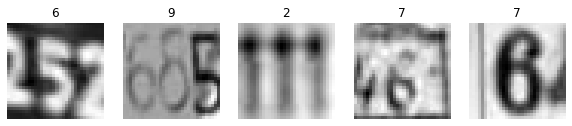

In [20]:
plot_images(X_train_gray[0:5], y_train[0:5],grayscale = True);

## Fitting models to the grayscale images ##

In [31]:
knn(X_train_gray_2_dim, X_test_gray_2_dim, y_train, y_test)

KNN evaluation

Training accuracy: 59.1%
Test accuracy: 38.2%
3-folds cross-validation score: 38.2 (+/- 0.8)%


0.38170823915282437

In [32]:
logreg(X_train_gray_2_dim, X_test_gray_2_dim, y_train, y_test);

Logistic regression evaluation

Training accuracy: 48.5%
Test accuracy: 15.5%
3-folds cross-validation score: 16.5 (+/- 0.4)%


In [33]:
lsvm(X_train_gray_2_dim, X_test_gray_2_dim, y_train, y_test);

Linear support vector machine evaluation

Training accuracy: 18.8%
Test accuracy: 12.2%
3-folds cross-validation score: 12.9 (+/- 9.8)%


## Discussion ##

Only KNN slightly improve its performance (roughly 2%), whereas logistic regression and svm drastically decrease. However, theoretically we should see an increase in performance because transorming the images into a gray scale reduce the dimensionality. Due to the curse of dimensionality, having less features increases the probability of finding patterns in the data. However, normalizing the data yelds better results with gray images. Thus, we suppose that after the conversion into gray scale the difference in the absolute values among features increases and is the cause of decreasing in performance.

## Normalizing ##

In [12]:
X_train_gray_normalized = copy.deepcopy(X_train_gray_2_dim)
X_test_gray_normalized = copy.deepcopy(X_test_gray_2_dim)

def normalize(X, X_original):
    for row in range(X.shape[0]):
        for column in range(len(X[row,:])):
            X[row,column] = (X[row,column]-X_original[row].mean())/X_original[row].std()

#Normalizing the gray images
normalize(X_test_gray_normalized, X_train_gray_2_dim);
normalize(X_train_gray_normalized, X_train_gray_2_dim);

In [13]:
#Normalizing the color images
X_train_normalized = copy.deepcopy(X_train)
X_test_normalized = copy.deepcopy(X_test)

normalize(X_test_normalized, X_test);
normalize(X_train_normalized, X_train);

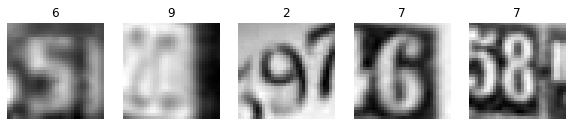

In [39]:
#Plotting to see wheter the normalization was correct
plot_images(X_train_gray_normalized[0:5], y_train[0:5],grayscale = True);

In [ ]:
X_train_gray_normalized[1,1:5], X_train_gray_2_dim[1,1:5]

## Fitting models to normalized grayscale images and to normalized color images ##

In [27]:
#KNN evaluation with grey scaled images
knn(X_train_gray_normalized, X_test_gray_normalized, y_train, y_test);

KNN evaluation

Training accuracy: 71.2%
Test accuracy: 54.0%
3-folds cross-validation score: 51.8 (+/- 2.9)%


In [28]:
#KNN evaluation with color scaled images
knn(X_train_normalized, X_test_normalized, y_train, y_test);

KNN evaluation

Training accuracy: 63.3%
Test accuracy: 46.1%
3-folds cross-validation score: 45.7 (+/- 0.5)%


In [29]:
#Logistic Regression with scaled gray images
print('Logistic regression evaluation with gray scale images')
logreg(X_train_gray_normalized, X_test_gray_normalized, y_train, y_test);
print('\n')
#Logistic Regression with scaled color images
print('Logistic regression with color scaled images')
logreg(X_train_normalized, X_test_normalized, y_train, y_test);


Logistic regression evaluation with gray scale images
Logistic regression evaluation

Training accuracy: 44.4%
Test accuracy: 18.3%
3-folds cross-validation score: 19.4 (+/- 0.3)%
Logistic regression with color scaled images
Logistic regression evaluation

Training accuracy: 99.1%
Test accuracy: 13.8%
3-folds cross-validation score: 14.4 (+/- 0.0)%


In [30]:
#Suppert vector machine with scaled gray images
print('gray images')
print('Linear support vector machine with scaled gray images')
lsvm(X_train_gray_normalized, X_test_gray_normalized, y_train, y_test);
print('\n')
#Support vector machine with scaled color images
print('color images')
print('Linear support vector machine with scaled color images')
lsvm(X_train_normalized, X_test_normalized, y_train, y_test);


Linear support vector machine with scaled gray images
Linear support vector machine evaluation

Training accuracy: 32.2%
Test accuracy: 14.1%
3-folds cross-validation score: 16.1 (+/- 1.4)%
Linear support vector machine with scaled color images
Linear support vector machine evaluation

Training accuracy: 99.7%
Test accuracy: 13.1%
3-folds cross-validation score: 14.0 (+/- 1.3)%


## Discussion ##
Scaling the pixels yelds better performance for every model we used. With KNN the accuracy significantly increases (about 20% from the evaluation with the original data), while with logistic regression and svm slightly improves. Probably, some pixel where consistently greater in absolute value then others, so they where taken as more relevant by the model. Scaling reduce the difference in the pixels' values, ranging them in a smaller interval.

## Principal component analysis ##

In [26]:
pipe_svm = Pipeline([("pca", PCA(n_components = 'mle')), ("svm",LinearSVC())])

pipe_svm.fit(X_train_gray_normalized, y_train)
print("Test score: {:.2f}".format(pipe_svm.score(X_test_gray_normalized, y_test)))
print("Train score: {:.2f}".format(pipe_svm.score(X_train_gray_normalized, y_train)))



Test score: 0.16
Train score: 0.34


In [27]:
pipe_logreg = Pipeline([("pca", PCA(n_components = 'mle')), ('logisticreg',LogisticRegression())])

pipe_logreg.fit(X_train_gray_normalized, y_train)
print("Test score: {:.2f}".format(pipe_logreg.score(X_test_gray_normalized, y_test)))
print("Train score: {:.2f}".format(pipe_logreg.score(X_train_gray_normalized, y_train)))

Test score: 0.18
Train score: 0.44


In [28]:
pipe_knn = Pipeline([("pca", PCA(n_components = 'mle')), ('knn',KNeighborsClassifier())])

pipe_knn.fit(X_train_gray_normalized, y_train)
print("Test score: {:.2f}".format(pipe_knn.score(X_test_gray_normalized, y_test)))
print("Train score: {:.2f}".format(pipe_knn.score(X_train_gray_normalized, y_train)))

Test score: 0.54
Train score: 0.71


After applying principal component analysis every model performe roughly the same as without applying it. I think in this case the benefit from dimensionality reduction is componsated from the lack of information projecting the features. 

## 4. Regularization (20 points) {-}
- Tune the algorithm's main regularization hyperparameter on the 10% stratified subsample using the normalized grayscale representation. These are the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. 
- We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied logarithmically, n_neighbors linearly. 
- Run a grid search over these ranges, using 3-fold cross-valdation, and plot both the training and test error. Start with a coarse grid (e.g. 5 values per hyperparameter), use a finer grid for the 'interesting' regions (where performance changes) if training time allows.
- Plot the effect of every one of the hyperparameters (both the training and test score). Discuss the plots. For which values is the model over/underfitting? Is there a sweet spot?
- Evaluate the optimized models (the best hyperparameter settings) on the rest of the (unseen) data and discuss your findings. Do the results generalize? If not, what can/ should you do? Discuss. Run additional experiments if it helps you confirm your claims.

### <span style="color:blue">Here exercise 4 and 5 is done with a small subsample, only 500 rows. This is used as a training set hence you see no use of $train\_test\_split$. This is done so it can quickly be checked that the syntax is correct. The whole dataset will be processed overnight by just changing the cell straightbelow. </span>

In [215]:
xtrain = X[:5000]
ytrain = y[:5000]

xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, train_size=0.2, test_size=0.8, random_state=0)

#converting both the training and testset to rgb
xtrain = rgb2gray(xtrain)
xtrain = xtrain[:, :, 0]
xtrain = StandardScaler().fit_transform(xtrain)

xtest = rgb2gray(xtest)
xtest = xtest[:, :, 0]
xtest = StandardScaler().fit_transform(xtest)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


### <span style="color:blue">For SVM and LogRes, we alter the value of C. For SVM this is the penalty parameter C of the error termand for LogRes this is Inverse of regularization strength. For KNN, $n$ is the numbers of neighbors. So all three algorithms are ran, with varying 1 hyperparameter only. </span>

In [216]:
#Regularization range for gridsearch
maxpower = 4
j = list(range(-maxpower,maxpower+1))
p = [10]*len(j)
crange = [p**j for p,j in zip(p,j)]

In [217]:
#neighbor range for gridsearch
maxneighbor = 6
nrange = list(range(1,maxneighbor+1))

In [218]:
#Gridsearch svm
parameters = [{'C': crange, 'kernel': ['linear']}]
gssvm = GridSearchCV(estimator = svm.SVC(kernel = 'linear', random_state=0),
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv=3)

gssvm = gssvm.fit(xtrain,ytrain)

#overview of "everything" from the gridsearch in a pd dataframe
#df = pd.DataFrame.from_dict(gssvm.cv_results_)
print(gssvm.best_estimator_)
print(gssvm.best_score_)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)
0.251


In [219]:
#Gridsearch LogReg
parameters = [{'C': crange}]
gslogreg = GridSearchCV(estimator = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000, random_state=0),
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv=3)

gslogreg = gslogreg.fit(xtrain,ytrain)

print(gslogreg.best_estimator_)
print(gslogreg.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.215


In [220]:
#Gridsearch knn
parameters = [{'n_neighbors': nrange}]
gsknn = GridSearchCV(estimator = KNeighborsClassifier(),
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv=3)

gsknn = gsknn.fit(xtrain,ytrain)

print(gsknn.best_estimator_)
print(gsknn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
0.247


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 5. Interpreting misclassifications (10 points) {-}
- Chances are that your best model is not 100% accurate. Plot a few of the misclassified examples and their predicted and correct labels. Discuss. Are these indeed 'hard' examples that are easy to get wrong?
- Plot the confusion matrix. Which digits are often confused with each other? Which digits are easier/harder to classify? Discuss.

### <span style="color:blue">This exercise is basically one command, it is not clear if you have to use grayscale or color, for now, grayscale is used. Also, it is not clear for which algorithm this must be done... Here, KNN is used with the optimal values from the gridsearch.</span>

In [233]:
model = KNeighborsClassifier().fit(xtrain,ytrain)

ypred = model.predict(xtest)

print(sklearn.metrics.confusion_matrix(ytest,ypred))
print(sklearn.metrics.accuracy_score(ytest,ypred))

[[539  65  53  41  14  15  10   3  11   9]
 [225 165  60  26  18  20   9  13   9  11]
 [183  86  95  25  15  10   8  17  10   7]
 [203  24  37  93  12  25   3  15  11   6]
 [159  40  56  24  24  32   9  18  11  10]
 [ 92  24  34  25  17  36   3  23  13  18]
 [136  46  47   8  10  11  17   6   7  10]
 [102  29  48  23  13  31   1  21  12  11]
 [100  38  34  15  10  14   4   8  18  14]
 [ 97  41  35  24   8  17   4  13  14  34]]
0.2605


### <span style="color:blue"> And for SVM and logreg: </span>

In [234]:
model = svm.SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False).fit(xtrain,ytrain)

ypred = model.predict(xtest)

print(sklearn.metrics.confusion_matrix(ytest,ypred))
print(sklearn.metrics.accuracy_score(ytest,ypred))

[[646  37  21  14  19   8   3   6   3   3]
 [369  72  34  18  29  10   6   5   3  10]
 [287  33  57  15  28  10   7   6   6   7]
 [330  17  21  31  13   2   4   4   2   5]
 [218  34  41   7  39  18   1  13   7   5]
 [176  20  13   9  22  19   4  11   6   5]
 [180  34  11  33  25   6   4   3   1   1]
 [172  15  22   9  21  25   4  14   6   3]
 [150  23  27  10  18   4   0   7   9   7]
 [191  29  12   8  21   2   6   2   3  13]]
0.226


In [236]:
model = LogisticRegression().fit(xtrain,ytrain)

ypred = model.predict(xtest)

print(sklearn.metrics.confusion_matrix(ytest,ypred))
print(sklearn.metrics.accuracy_score(ytest,ypred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[288  98  57  72  56  45  30  35  26  53]
 [154 105  60  42  40  39  30  27  32  27]
 [140  62  61  44  39  29  12  23  25  21]
 [121  56  49  69  22  27  16  22  20  27]
 [105  40  44  28  41  31  22  28  24  20]
 [ 85  38  29  17  28  26   8  20  13  21]
 [ 81  53  26  29  24  24  15  24  10  12]
 [ 76  30  39  15  33  38   9  24  10  17]
 [ 71  32  25  22  25  20   8  13  24  15]
 [ 75  32  29  26  30  16  16  12  15  36]]
0.17225


### <span style="color:blue"> Exercise 4 and 5 are done in the sense that the code is written for it, it has to be run over the full hyperparameter span for the full 10% subset. The results yet are simply too bad yet to write any discussion... </span>

## 6. Interpreting models (15 points) {-}
- Try to understand what the linear models have learned by looking at their model parameters. Are there features (pixels) that are more important than others? What does that tell you?
- Visualize the model parameters of the best (tuned) models as a 32x32 matrix, for each class individually. This means training 10 models in a one-vs-all fashion. Does this help you understand what the model is paying attention to?
- Do the same for an underfitted and an overfitted version of logistic regression. What changes? Is the model paying attention to different parts of the image now?

Good luck!